# Anomaly Detector on HTTP CSIC Dataset

The goal of this report is to learn how to use a different approach from binary classifiers, specifically how anomaly detectors are trained. Unlike binary classifiers where classes are usually equally represented in the population, anomaly detectors are more useful in populations where normal data exists a lot more than anomalous data points. Hence, the training set used in this report will purely be normal data, unlike stratified splits in other binary classifiers' exploration. While similar models are used, OneClassSVM and IsolationForests are slightly different from SVM and RandomForestClassifiers. At the end of the report, I hope to have been able to choose a specific model as my best choice in being utilised as an anomaly detector for this dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns=100

In [2]:
normalTrainingDataFrame = pd.read_csv("normalTrafficTraining_http_requests.csv")
normalTestDataFrame = pd.read_csv("normalTrafficTest_http_requests.csv")
anomalousTestDataFrame = pd.read_csv("anomalousTrafficTest_http_requests.csv")

In [3]:
testDataFrame = normalTestDataFrame.append(anomalousTestDataFrame, ignore_index=True)

In [4]:
normalTrainingDataFrame = normalTrainingDataFrame.drop(columns="Unnamed: 0")
testDataFrame = testDataFrame.drop(columns="Unnamed: 0")

Dropping Trivial Features' columns

In [5]:
# Finding the indexes of the columns to drop

num_columns = len(testDataFrame.columns)
cols_to_drop_index = []

for i in range(num_columns):
    if len(testDataFrame.iloc[:,i].value_counts()) == 1:
        cols_to_drop_index = cols_to_drop_index + [i]

In [6]:
# Finding the name of the columns to drop

df_columns = testDataFrame.columns
cols_to_drop_name = []

for i in range(len(cols_to_drop_index)):
    next_drop = df_columns[cols_to_drop_index[i]]
    cols_to_drop_name = cols_to_drop_name + [next_drop]

In [7]:
normalTrainingDataFrame.drop(cols_to_drop_name, axis=1, inplace=True)
testDataFrame.drop(cols_to_drop_name, axis=1, inplace=True)

Pre-Processing of Columns

In [8]:
# Re-ordering columns
def re_order_last_col_to_front(df):
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    return df

In [9]:
normalTrainingDataFrame = re_order_last_col_to_front(normalTrainingDataFrame)
testDataFrame = re_order_last_col_to_front(testDataFrame)

Features Manipulation - Based on experience in the binary classifier

In [10]:
normalTrainingDataFrame = normalTrainingDataFrame.drop(columns=['Host', 'Cookie'])
testDataFrame = testDataFrame.drop(columns=['Host', 'Cookie'])

In [11]:
# Dropping "http://localhost:8080" from request_addres
normalTrainingDataFrame.rename(columns={'Request_Address':'Request_Address_URI'}, inplace=True)
testDataFrame.rename(columns={'Request_Address':'Request_Address_URI'}, inplace=True)
normalTrainingDataFrame['Request_Address_URI'] = normalTrainingDataFrame['Request_Address_URI'].apply(lambda x: x[21:])
testDataFrame['Request_Address_URI'] = testDataFrame['Request_Address_URI'].apply(lambda x: x[21:])

In [12]:
normalTrainingDataFrame['Content-Length'] = normalTrainingDataFrame['Content-Length'].replace(np.nan, 0)
testDataFrame['Content-Length'] = testDataFrame['Content-Length'].replace(np.nan, 0)

In [13]:
normalTrainingDataFrame['No_of_slashes'] = normalTrainingDataFrame.apply(lambda row: row.Request_Address_URI.count("/"), axis=1)
normalTrainingDataFrame['No_of_questions'] = normalTrainingDataFrame.apply(lambda row: row.Request_Address_URI.count("?"), axis=1)
normalTrainingDataFrame['No_of_equals'] = normalTrainingDataFrame.apply(lambda row: row.Request_Address_URI.count("="), axis=1)

testDataFrame['No_of_slashes'] = testDataFrame.apply(lambda row: row.Request_Address_URI.count("/"), axis=1)
testDataFrame['No_of_questions'] = testDataFrame.apply(lambda row: row.Request_Address_URI.count("?"), axis=1)
testDataFrame['No_of_equals'] = testDataFrame.apply(lambda row: row.Request_Address_URI.count("="), axis=1)

In [14]:
normalTrainingDataFrame['Put_Request'] = normalTrainingDataFrame['Request_Type'] == "PUT"
testDataFrame['Put_Request'] = testDataFrame['Request_Type'] == "PUT"

In [15]:
normalTrainingDataFrame['No_of_ampersands'] = normalTrainingDataFrame.apply(lambda row: row.Request_Address_URI.count("&"), axis=1)
normalTrainingDataFrame['No_of_periods'] = normalTrainingDataFrame.apply(lambda row: row.Request_Address_URI.count("."), axis=1)

testDataFrame['No_of_ampersands'] = testDataFrame.apply(lambda row: row.Request_Address_URI.count("&"), axis=1)
testDataFrame['No_of_periods'] = testDataFrame.apply(lambda row: row.Request_Address_URI.count("."), axis=1)

In [16]:
normalTrainingDataFrame['Length_of_URI'] = normalTrainingDataFrame.apply(lambda row: len(row.Request_Address_URI), axis=1)

testDataFrame['Length_of_URI'] = testDataFrame.apply(lambda row: len(row.Request_Address_URI), axis=1)

In [17]:
def get_ext(uri):
    tokens = uri.split(".")
    if len(tokens)==1:
        return ""
    else:
        return tokens[len(tokens)-1]
    
def get_final_file(uri):
    tokens = uri.split("/")
    return tokens[len(tokens)-1]

# To try and find bad extensions
def max_no_of_periods_between_slashes(uri):
    num_found = 0
    tokens = uri.split("/")
    for token in tokens:
        num_in_token = token.count(".")
        if num_in_token > num_found:
            num_found = num_in_token
    return num_found

In [18]:
normalTrainingDataFrame['URI_ext'] = normalTrainingDataFrame.apply(lambda row: get_ext(row.Request_Address_URI), axis=1)
normalTrainingDataFrame['URI_file'] = normalTrainingDataFrame.apply(lambda row: get_final_file(row.Request_Address_URI), axis=1)
normalTrainingDataFrame['Max_no_periods_between_slashes'] = normalTrainingDataFrame.apply(lambda row: max_no_of_periods_between_slashes(row.Request_Address_URI), axis=1)
normalTrainingDataFrame['URI_ext_end_with_alpha'] = normalTrainingDataFrame.apply(lambda row: row.URI_ext[-1:].isalpha(), axis=1)
normalTrainingDataFrame['URI_ext_end_with_numeric'] = normalTrainingDataFrame.apply(lambda row: row.URI_ext[-1:].isdigit(), axis=1)
normalTrainingDataFrame['URI_has_CAPS'] = normalTrainingDataFrame.apply(lambda row: any(x.isupper() for x in row.Request_Address_URI), axis=1)

testDataFrame['URI_ext'] = testDataFrame.apply(lambda row: get_ext(row.Request_Address_URI), axis=1)
testDataFrame['URI_file'] = testDataFrame.apply(lambda row: get_final_file(row.Request_Address_URI), axis=1)
testDataFrame['Max_no_periods_between_slashes'] = testDataFrame.apply(lambda row: max_no_of_periods_between_slashes(row.Request_Address_URI), axis=1)
testDataFrame['URI_ext_end_with_alpha'] = testDataFrame.apply(lambda row: row.URI_ext[-1:].isalpha(), axis=1)
testDataFrame['URI_ext_end_with_numeric'] = testDataFrame.apply(lambda row: row.URI_ext[-1:].isdigit(), axis=1)
testDataFrame['URI_has_CAPS'] = testDataFrame.apply(lambda row: any(x.isupper() for x in row.Request_Address_URI), axis=1)

In [19]:
normalTrainingDataFrame['URI_ext_shortened'] = normalTrainingDataFrame.apply(lambda row: row.URI_ext[:3], axis=1)

testDataFrame['URI_ext_shortened'] = testDataFrame.apply(lambda row: row.URI_ext[:3], axis=1)

In [20]:
import math

# Referenced from https://stackoverflow.com/questions/1547899/which-characters-make-a-url-invalid 
URI_CHARS_LIST = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789-._~:/?#[]@!$&'()*+,;="

def shannon_entropy(data, iterator):
    """
    Borrowed from http://blog.dkbza.org/2007/05/scanning-data-for-entropy-anomalies.html
    """
    if not data:
        return 0
    entropy = 0
    for x in iterator:
        p_x = float(data.count(x))/len(data)
        if p_x > 0:
            entropy += - p_x*math.log(p_x, 2)
    return entropy

In [21]:
normalTrainingDataFrame['Entropy'] = normalTrainingDataFrame.apply(lambda row: shannon_entropy(row.Request_Address_URI, URI_CHARS_LIST), axis=1)

testDataFrame['Entropy'] = testDataFrame.apply(lambda row: shannon_entropy(row.Request_Address_URI, URI_CHARS_LIST), axis=1)

In [22]:
normalTrainingDataFrame['Length_of_URI_File'] = normalTrainingDataFrame.apply(lambda row: len(row.URI_file), axis=1)

testDataFrame['Length_of_URI_File'] = testDataFrame.apply(lambda row: len(row.URI_file), axis=1)

In [23]:
# Static Attacks Detection

# To detect JSESSION_ID in URL Rewrite, none of rows contain "jsessionid="
normalTrainingDataFrame['Has_set-cookie'] = normalTrainingDataFrame.apply(lambda row: "Set-cookie" in row.Request_Address_URI, axis=1)

testDataFrame['Has_set-cookie'] = testDataFrame.apply(lambda row: "Set-cookie" in row.Request_Address_URI, axis=1)

# Identify accesses to backup files
normalTrainingDataFrame['Access_backup'] = normalTrainingDataFrame.apply(lambda row: (row.URI_ext).lower() == "bak", axis=1)

testDataFrame['Access_backup'] = testDataFrame.apply(lambda row: (row.URI_ext).lower() == "bak", axis=1)

# Identify accesses to config files
normalTrainingDataFrame['Access_config'] = normalTrainingDataFrame.apply(lambda row: (row.URI_ext).lower() == "cnf", axis=1)

testDataFrame['Access_config'] = testDataFrame.apply(lambda row: (row.URI_ext).lower() == "cnf", axis=1)

# Identify accesses to default index.html file
normalTrainingDataFrame['Access_index_html'] = normalTrainingDataFrame.apply(lambda row: "index.html" in row.Request_Address_URI, axis=1)

testDataFrame['Access_index_html'] = testDataFrame.apply(lambda row: "index.html" in row.Request_Address_URI, axis=1)

In [24]:
# Dynamic Attacks Detection

# Identify possible SQL Commands
def spot_sql(uri):
    return ("SELECT" in uri or "FROM" in uri or "UNION" in uri or "OR" in uri or "--" in uri or "/**/" in uri or "INSERT" in uri or "UPDATE" in uri or "DELETE" in uri or "CREATE" in uri or "ALTER" in uri or "DROP" in uri)

normalTrainingDataFrame['Possible_SQL_Injection'] = normalTrainingDataFrame.apply(lambda row: spot_sql(row.Request_Address_URI), axis=1)
testDataFrame['Possible_SQL_Injection'] = testDataFrame.apply(lambda row: spot_sql(row.Request_Address_URI), axis=1)

In [25]:
# Cross site scripting
normalTrainingDataFrame['Contains_script_word'] = normalTrainingDataFrame.apply(lambda row: "script" in row.Request_Address_URI.lower(), axis=1)
normalTrainingDataFrame['Contains_script_word'] = normalTrainingDataFrame.apply(lambda row: "script" in row.Request_Address_URI.lower(), axis=1)

testDataFrame['Contains_another_http'] = testDataFrame.apply(lambda row: "http" in row.Request_Address_URI.lower(), axis=1)
testDataFrame['Contains_another_http'] = testDataFrame.apply(lambda row: "http" in row.Request_Address_URI.lower(), axis=1)

Tidying up of Table - Enumeration and Dropping Features

In [26]:
normalTrainingDataFrame = normalTrainingDataFrame.drop(columns=['URI_ext', 'URI_file', 'URI_ext_shortened', 'Request_Address_URI', 'Request_Type'])
testDataFrame = testDataFrame.drop(columns=['URI_ext', 'URI_file', 'URI_ext_shortened', 'Request_Address_URI', 'Request_Type'])

In [27]:
normalTrainingDataFrame = normalTrainingDataFrame.replace([True, False], [1, 0])
normalTrainingDataFrame = normalTrainingDataFrame.replace(['No', 'Yes'], [-1,1])

testDataFrame = testDataFrame.replace([True, False], [1, 0])
testDataFrame = testDataFrame.replace(['No', 'Yes'], [-1,1])


In [28]:
X_train = normalTrainingDataFrame.drop(columns='Normal_Access')
y_train = normalTrainingDataFrame['Normal_Access']

In [29]:
X_test = testDataFrame.drop(columns='Normal_Access')
y_test = testDataFrame['Normal_Access']

## Baseline Models

In [30]:
# One class svm
from sklearn import svm

svm_clf = svm.OneClassSVM()
svm_clf.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [31]:
y_pred_test = svm_clf.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

result_df_columns = ['Classifier', 'Accuracy', 'Precision (Binary)', 'Recall (Binary)', 'F1 (Binary)']
results_dataframe = pd.DataFrame(columns=result_df_columns)


In [33]:
# X_test

x_test_acc = accuracy_score(y_test, y_pred_test)
x_test_prec = precision_score(y_test, y_pred_test, average='binary')
x_test_rec = recall_score(y_test, y_pred_test, average='binary')
x_test_f1 = f1_score(y_test, y_pred_test, average='binary')

x_test_res = ["One Class SVM", x_test_acc, x_test_prec, x_test_rec, x_test_f1]
x_test_df = pd.DataFrame([x_test_res], columns=result_df_columns)

results_dataframe = results_dataframe.append(x_test_df, ignore_index=True)

In [34]:
# isolation forest

In [35]:
from sklearn.ensemble import IsolationForest

forest_clf = IsolationForest()
forest_clf.fit(X_train)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [36]:
y_forest_pred_test = forest_clf.predict(X_test)

In [37]:
x_forest_test_acc = accuracy_score(y_test, y_forest_pred_test)
x_forest_test_prec = precision_score(y_test, y_forest_pred_test, average='binary')
x_forest_test_rec = recall_score(y_test, y_forest_pred_test, average='binary')
x_forest_test_f1 = f1_score(y_test, y_forest_pred_test, average='binary')

x_forest_test_res = ["Isolation Forest", x_forest_test_acc, x_forest_test_prec, x_forest_test_rec, x_forest_test_f1]
x_forest_test_df = pd.DataFrame([x_forest_test_res], columns=result_df_columns)

results_dataframe = results_dataframe.append(x_forest_test_df, ignore_index=True)

In [38]:
results_dataframe

,Classifier,Accuracy,Precision (Binary),Recall (Binary),F1 (Binary)
0,One Class SVM,0.662786,0.934322,0.460361,0.616807
1,Isolation Forest,0.660346,0.654159,0.899306,0.757390


As the results show, there is a trade-off to be had, as One Class SVM has high precision but low recall, while Isolation Forest has decent precision and high recall. In order to test this balance, we can consider the F1-Score, which represents the harmonic average between precision and recall. Hence, I would be leaning towards Isolation Forest as a better option. Despite this, I will still consider both One Class SVM and Isolation Forests in future iterations to improve on the current scores achieved. I would also plot a Precision Recall Curve below to analyse the trade-offs further.

### Precision Recall Curve

In [75]:
forest_y_score = forest_clf.decision_function(X_test)
svm_y_score = svm_clf.decision_function(X_test)

In [76]:
from sklearn.metrics import average_precision_score

forest_average_precision = average_precision_score(y_test, forest_y_score)
svm_average_precision = average_precision_score(y_test, svm_y_score)

print('Forest average precision-recall score: {0:0.2f}'.format(
      forest_average_precision))
print('SVM average precision-recall score: {0:0.2f}'.format(
      svm_average_precision))

Forest average precision-recall score: 0.81
SVM average precision-recall score: 0.86


Text(0.5,1,'Precision Recall Curve for IsolationForest and OneClassSVM')

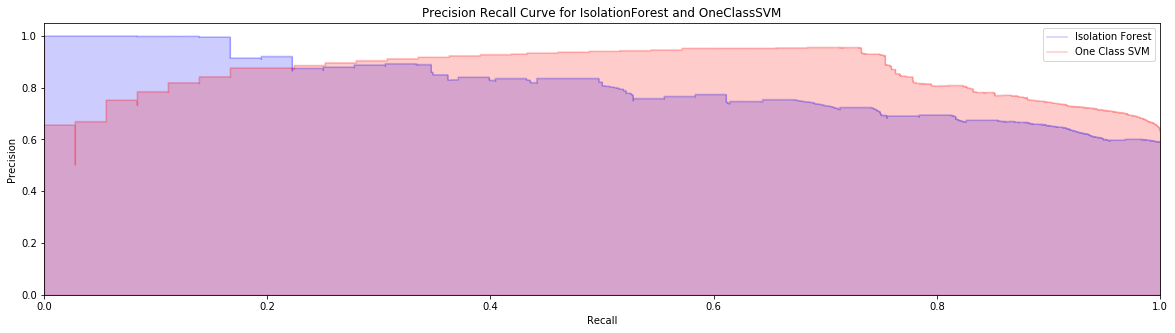

In [84]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

for_precision, for_recall, for_k = precision_recall_curve(y_test, forest_y_score)
svm_precision, svm_recall, svm_k = precision_recall_curve(y_test, svm_y_score)

plt.figure(figsize=(20,5))

plt.step(for_recall, for_precision, color='b', label='Isolation Forest', alpha=0.2,
         where='post')
plt.step(svm_recall, svm_precision, color='r', label= 'One Class SVM', alpha=0.2,
         where='post')

plt.legend()

plt.fill_between(for_recall, for_precision, step='post', alpha=0.2,
                 color='b')

plt.fill_between(svm_recall, svm_precision, step='post', alpha=0.2,
                 color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall Curve for IsolationForest and OneClassSVM')

With the curve plotted, it can be visualised that neither model truly dominates the other model. Hence, I would be referring back to the F1-Score to state a preference towards Isolation Forest, but once again, it has to be explored further below.

## Future Iterations

Based on the research done within the binary classifier report, I managed to identify 4 features which seem more important than the others. By only choosing these 4 features to simplify the model, I hope to reduce the curse of dimensionality and test Occam's Razor.

### Reduced Features

In [39]:
# Reduced Features
most_impt_features_train = X_train[['Content-Length', 'Length_of_URI_File', 'Entropy', 'Length_of_URI']]
most_impt_features_test = X_test[['Content-Length', 'Length_of_URI_File', 'Entropy', 'Length_of_URI']]

In [40]:
most_impt_features_test.head()

,Content-Length,Length_of_URI_File,Entropy,Length_of_URI
0,0.0,9,3.614369,18
1,0.0,85,4.546791,102
2,74.0,10,4.004344,27
3,0.0,75,4.435028,92
4,60.0,14,4.018082,31


In [42]:
svm_reduced_clf = svm.OneClassSVM()
svm_reduced_clf.fit(most_impt_features_train)

forest_red_clf = IsolationForest()
forest_red_clf.fit(most_impt_features_train)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [43]:
y_red_svm_pred_test = svm_reduced_clf.predict(most_impt_features_test)
y_red_for_pred_test = forest_red_clf.predict(most_impt_features_test)

In [44]:
results_reducedfeat_dataframe = pd.DataFrame(columns=result_df_columns)

In [45]:
# X_test

x_test_red_acc = accuracy_score(y_test, y_red_svm_pred_test)
x_test_red_prec = precision_score(y_test, y_red_svm_pred_test, average='binary')
x_test_red_rec = recall_score(y_test, y_red_svm_pred_test, average='binary')
x_test_red_f1 = f1_score(y_test, y_red_svm_pred_test, average='binary')

x_test_red_res = ["One Class SVM", x_test_red_acc, x_test_red_prec, x_test_red_rec, x_test_red_f1]
x_test_red_df = pd.DataFrame([x_test_red_res], columns=result_df_columns)

results_reducedfeat_dataframe = results_reducedfeat_dataframe.append(x_test_red_df, ignore_index=True)

In [46]:
x_reduced_forest_test_acc = accuracy_score(y_test, y_red_for_pred_test)
x_reduced_forest_test_prec = precision_score(y_test, y_red_for_pred_test, average='binary')
x_reduced_forest_test_rec = recall_score(y_test, y_red_for_pred_test, average='binary')
x_reduced_forest_test_f1 = f1_score(y_test, y_red_for_pred_test, average='binary')

x_reduced_forest_test_res = ["Isolation Forest", x_reduced_forest_test_acc, x_reduced_forest_test_prec, x_reduced_forest_test_rec, x_reduced_forest_test_f1]
x_reduced_forest_test_df = pd.DataFrame([x_reduced_forest_test_res], columns=result_df_columns)

results_reducedfeat_dataframe = results_reducedfeat_dataframe.append(x_reduced_forest_test_df, ignore_index=True)

In [47]:
results_reducedfeat_dataframe

,Classifier,Accuracy,Precision (Binary),Recall (Binary),F1 (Binary)
0,One Class SVM,0.63737,0.989819,0.388889,0.558392
1,Isolation Forest,0.65915,0.653369,0.898528,0.756584


Despite the very high precision from the One Class SVM, the trade-off of having such a low recall is not worthwhile. The F1-Score once again leans towards the Isolation Forest as a better option, and I will solely consider the Isolation Forest from here onwards. In order to optimise the model, we can tweak the hyper-parameters to find an ideal set, using Grid Search CV.

### Grid Search CV

As Isolation Forest does not have a "score" method, I have decided to embark on a manual grid search CV exploration. The alternative would have been to develop a callable scoring strategy, which I chose not to do so.

In [ ]:
estimator_params = [50,100,150,200,250]
max_feats_params = [5,10,15,20,1.0]

gscv_df_columns = ['Classifier', 'Estimators', 'Max_feats', 'Accuracy', 'Precision (Binary)', 'Recall (Binary)', 'F1 (Binary)']
gscv_dataframe = pd.DataFrame(columns = gscv_df_columns)

for i in range(len(estimator_params)):
    for j in range(len(max_feats_params)):
        if_clf_gscv = IsolationForest(n_estimators=estimator_params[i], max_features=max_feats_params[j])
        if_clf_gscv.fit(X_train)
        y_gscv_pred_test = if_clf_gscv.predict(X_test)
        
        x_gscv_test_acc = accuracy_score(y_test, y_gscv_pred_test)
        x_gscv_test_prec = precision_score(y_test, y_gscv_pred_test, average='binary')
        x_gscv_test_rec = recall_score(y_test, y_gscv_pred_test, average='binary')
        x_gscv_test_f1 = f1_score(y_test, y_gscv_pred_test, average='binary')

        x_gscv_test_res = ["Isolation Forest", estimator_params[i], max_feats_params[j], x_gscv_test_acc, x_gscv_test_prec, x_gscv_test_rec, x_gscv_test_f1]
        x_gscv_test_df = pd.DataFrame([x_gscv_test_res], columns=gscv_df_columns)

        gscv_dataframe = gscv_dataframe.append(x_gscv_test_df, ignore_index=True)

In [56]:
gscv_dataframe.sort_values('F1 (Binary)', ascending=False).head()

,Classifier,Estimators,Max_feats,Accuracy,Precision (Binary),Recall (Binary),F1 (Binary)
18,Isolation Forest,200,20,0.671236,0.662935,0.899861,0.763439
19,Isolation Forest,200,1,0.668681,0.660675,0.900500,0.762167
11,Isolation Forest,150,10,0.668763,0.661018,0.899333,0.761976
8,Isolation Forest,100,20,0.667076,0.659371,0.900444,0.761279
22,Isolation Forest,250,15,0.666143,0.658659,0.900222,0.760724


Based on the table above, the ideal solution has 200 estimators and a maximum features value of 20. This has a slightly better F1-Score than the default model of 100 estimators and 1.0 maximum features, having 0.763 as compared to 0.757.

### K Folds CV

Having found a better model using Grid Search CV, I would be validating this model using K-Folds Cross validation, to ensure that the model works well thoroughly.

In [59]:
from sklearn.metrics.scorer import make_scorer

f1_scorer = make_scorer(f1_score, greater_is_better=True)

In [74]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=10, shuffle=True)
if_clf_k = IsolationForest(n_estimators=200, max_features=20)

np.mean(cross_val_score(if_clf_k, X_test, y_test, cv=kf, scoring=f1_scorer))

0.7568962197714819

## Conclusion

In [ ]:
# highlight the important bits